In [2]:
from MotionBERT.common_import import *

### Check torch function

In [4]:
checkpoint = 'MB_train_h36m_gt_cam_no_factor_input_from_canonical_pcl_original'
args, opts = get_opt_args_from_model_name(checkpoint, mode='best')
train_loader, test_loader, _, _, datareader = load_dataset(args, use_new_datareader=True)
#train_cam_param, test_cam_param = datareader.datareader[args.subset_list[0]].get_sliced_cam_param()

configs/pose3d/MB_train_h36m_gt_cam_no_factor_input_from_canonical_pcl_original.yaml
True
Loading dataset...
H36M-GT-CAM_NO_FACTOR-INPUT_FROM_CANONICAL_PCL_ORIGINAL
[overwrite: False] ==> Loading H36M source_list...
[overwrite: False] ==> Loading H36M cam_param...
[overwrite: False] ==> Loading H36M cam_3d...
[overwrite: False] ==> Loading H36M cam_3d_canonical_pcl_original...
[overwrite: False] ==> Loading H36M img_2d_canonical_pcl_original...


In [15]:
args.mask = (args.mask_ratio > 0 and args.mask_T_ratio > 0)
args.rootrel = False
args.fix_orientation_gt = True

total_error = 0
with torch.no_grad():
    for batch_input, batch_gt in test_loader: # batch_input: normalized joint_2d, batch_gt: normalized joint3d_image
        b, f, j, c = batch_input.shape
        batch_gt_original = batch_gt.clone().detach().cuda()
        batch_input, batch_gt, batch_gt_torso, batch_gt_limb_pos = preprocess_eval(args, batch_input, batch_gt)
        batch_gt_back = postprocess_eval(args, batch_gt, batch_gt_original, batch_input)
        batch_gt_original_reshaped = batch_gt_original.reshape(b*f, j, 3)
        batch_gt_reshaped = batch_gt.reshape(b*f, j, 3)
        batch_gt_back_reshaped = batch_gt_back.reshape(b*f, j, 3)
        total_error = torch.norm(batch_gt_original_reshaped - batch_gt_back_reshaped, dim=-1).mean()
        #break

In [16]:
total_error

tensor(2.4806e-07, device='cuda:0')

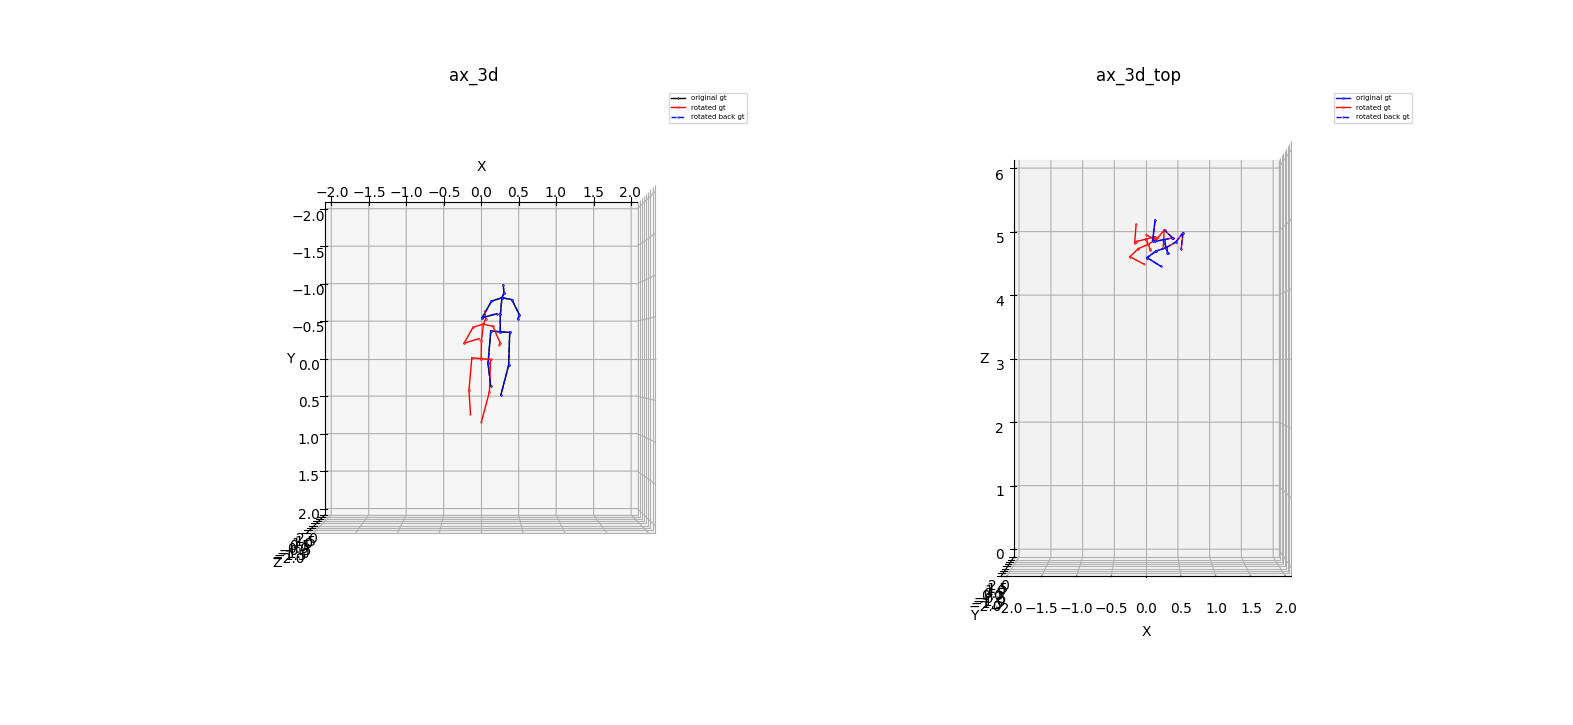

In [19]:
%matplotlib widget
batch_num = 5
pose3d = batch_gt_original.clone().detach().cpu().numpy()[batch_num]
rotated_3d = batch_gt.clone().detach().cpu().numpy()[batch_num]
rotated_back_3d = batch_gt_back.clone().detach().cpu().numpy()[batch_num]

frame_num = 50
configs = {
    'ax_3d': {'type': '3d', 'loc': 121, 'mode': 'cam'},
    'ax_3d_top': {'type': '3d', 'loc': 122, 'mode': 'cam_top', 'zlim': [0, 6]},
}
fig, axs = generate_axes(2, configs, fig_title='')
plot_pose_setting = [
    ('ax_3d', pose3d,           {'color': 'k', 'label': 'original gt'}),
    ('ax_3d', rotated_3d,           {'color': 'r', 'label': 'rotated gt'}),
    ('ax_3d', rotated_back_3d,           {'color': 'b', 'label': 'rotated back gt', 'linestyle': '--'}),
    ('ax_3d_top', pose3d,           {'color': '', 'label': 'original gt'}),
    ('ax_3d_top', rotated_3d,           {'color': 'r', 'label': 'rotated gt'}),
    ('ax_3d_top', rotated_back_3d,           {'color': 'b', 'label': 'rotated back gt', 'linestyle': '--'}),
]
general_plot_func(axs, configs, plot_pose_setting, frame_num)
plt.show()

In [5]:
np.linalg.norm(pose3d - rotated_back_3d, axis=1).mean()

5.326043e-07

### check get_R_virt2orig

In [8]:
checkpoint = 'MB_train_h36m_gt_cam_no_factor'
args, opts = get_opt_args_from_model_name(checkpoint, mode='best')
train_loader, test_loader, _, _, datareader = load_dataset(args, use_new_datareader=True)
#train_cam_param, test_cam_param = datareader.datareader[args.subset_list[0]].get_sliced_cam_param()

configs/pose3d/MB_train_h36m_gt_cam_no_factor.yaml
True
Loading dataset...
H36M-GT-CAM_NO_FACTOR
[overwrite: False] ==> Loading H36M source_list...
[overwrite: False] ==> Loading H36M cam_param...
[overwrite: False] ==> Loading H36M cam_3d...
[overwrite: False] ==> Loading H36M img_2d...


In [11]:
from hpe_library.my_utils.canonical import batch_rotation_matrix_from_vectors_torch
with torch.no_grad():
    for batch_input, batch_gt in test_loader:
        batch_v_origin_to_pelvis = batch_gt[:, :, 0]
        batch_v_origin_to_principle = torch.tensor([0, 0, 1], device=batch_gt.device).reshape(1, 1, 3).repeat(batch_gt.shape[0], batch_gt.shape[1], 1).float()
        assert batch_v_origin_to_principle.shape == batch_v_origin_to_pelvis.shape, (batch_v_origin_to_principle.shape, batch_v_origin_to_pelvis.shape)
        batch_R_orig2virt_from_3d_tensor = batch_rotation_matrix_from_vectors_torch(batch_v_origin_to_pelvis, batch_v_origin_to_principle)
        batch_R_orig2virt_from_3d_inv_tensor = torch.linalg.inv(batch_R_orig2virt_from_3d_tensor)
        batch_R_virt2orig_from_3d_tensor = batch_R_orig2virt_from_3d_inv_tensor
        batch_R_virt2orig_from_3d_inv_tensor = batch_R_orig2virt_from_3d_tensor

        batch_v_origin_to_pelvis_proj_on_xz = batch_v_origin_to_pelvis.clone()
        batch_v_origin_to_pelvis_proj_on_xz[:, :, 1] = 0
        batch_R1 = batch_rotation_matrix_from_vectors_torch(batch_v_origin_to_pelvis, batch_v_origin_to_pelvis_proj_on_xz)
        batch_R2 = batch_rotation_matrix_from_vectors_torch(batch_v_origin_to_pelvis_proj_on_xz, batch_v_origin_to_principle)
        batch_R_orig2virt_no_Rz_from_3d_tensor = torch.einsum('bfij,bfjk->bfik', batch_R2, batch_R1)
        batch_R_orig2virt_no_Rz_from_3d_tensor_inv = torch.linalg.inv(batch_R_orig2virt_no_Rz_from_3d_tensor)
        batch_R_virt2orig_no_Rz_from_3d_tensor = batch_R_orig2virt_no_Rz_from_3d_tensor_inv
        batch_R_virt2orig_no_Rz_from_3d_inv_tensor = batch_R_orig2virt_no_Rz_from_3d_tensor
        break

In [10]:
img_2d = batch_input.clone().detach().cpu().numpy()
cam_3d = batch_gt.clone().detach().cpu().numpy()
b, f, j, c = img_2d.shape

img_2d = img_2d.reshape(b*f, j, c)
cam_3d = cam_3d.reshape(b*f, j, c)

In [12]:
R_orig2virt_from_3d, R_orig2virt_from_3d_inv = get_batch_R_orig2virt_from_3d(cam_3d, no_Rz=False)
R_orig2virt_no_Rz_from_3d, R_orig2virt_no_Rz_from_3d_inv = get_batch_R_orig2virt_from_3d(cam_3d, no_Rz=True)

In [21]:
batch_R_orig2virt_from_3d_tensor_reshaped = batch_R_orig2virt_from_3d_tensor.reshape(b*f, 3, 3).detach().cpu().numpy()
batch_R_orig2virt_no_Rz_from_3d_tensor_reshaped = batch_R_orig2virt_no_Rz_from_3d_tensor.reshape(b*f, 3, 3).detach().cpu().numpy()

In [28]:
np.abs(batch_R_orig2virt_from_3d_tensor_reshaped - R_orig2virt_from_3d).mean()

1.0645231212723483e-08

In [26]:
np.abs(batch_R_orig2virt_no_Rz_from_3d_tensor_reshaped - R_orig2virt_no_Rz_from_3d).mean()

2.0209830904786812e-08